# Autoencoder for uninfected malaria cell images

## Imports

In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, MaxPooling2D, UpSampling2D, Dropout, LeakyReLU

from model_utility import get_image_data

In [2]:
tf.__version__

'2.3.0'

### Set logging to Error only

In [3]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

In [5]:
RANDOM_STATE = 7
BASE_PATH = r"D:\Programming\Datasets\Malaria Cell Images\Uninfected"
IMAGE_SIZE = (128, 128)
VAL_SIZE = 0.05
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
PLOTS_DPI = 200
MODEL_NAME = 'Autoencoder_Reconstruction'
PLOTS_DIR = os.path.join('plots', MODEL_NAME)

## Data Loading

In [6]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.png'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 13779


### Image data loading with augmentations

In [7]:
%%time

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = get_image_data(os.path.join(BASE_PATH, name), IMAGE_SIZE)

    img_rotpos90 = tf.image.rot90(img, k = 1).numpy()
    img_rotneg90 = tf.image.rot90(img, k = -1).numpy()

    imageData.append(img)
    imageData.append(img_rotpos90)
    imageData.append(img_rotneg90)
    
imageData = np.array(imageData).astype('float32')
imageData = imageData/255.0

(imageData.dtype, imageData.shape)

Loading image data: 100%|██████████| 13779/13779 [01:42<00:00, 134.65 images/s]
Wall time: 2min 30s


(dtype('float32'), (41337, 128, 128, 3))

In [8]:
imageData.min(), imageData.max()

(0.0, 1.0)

### Augmented data visualization

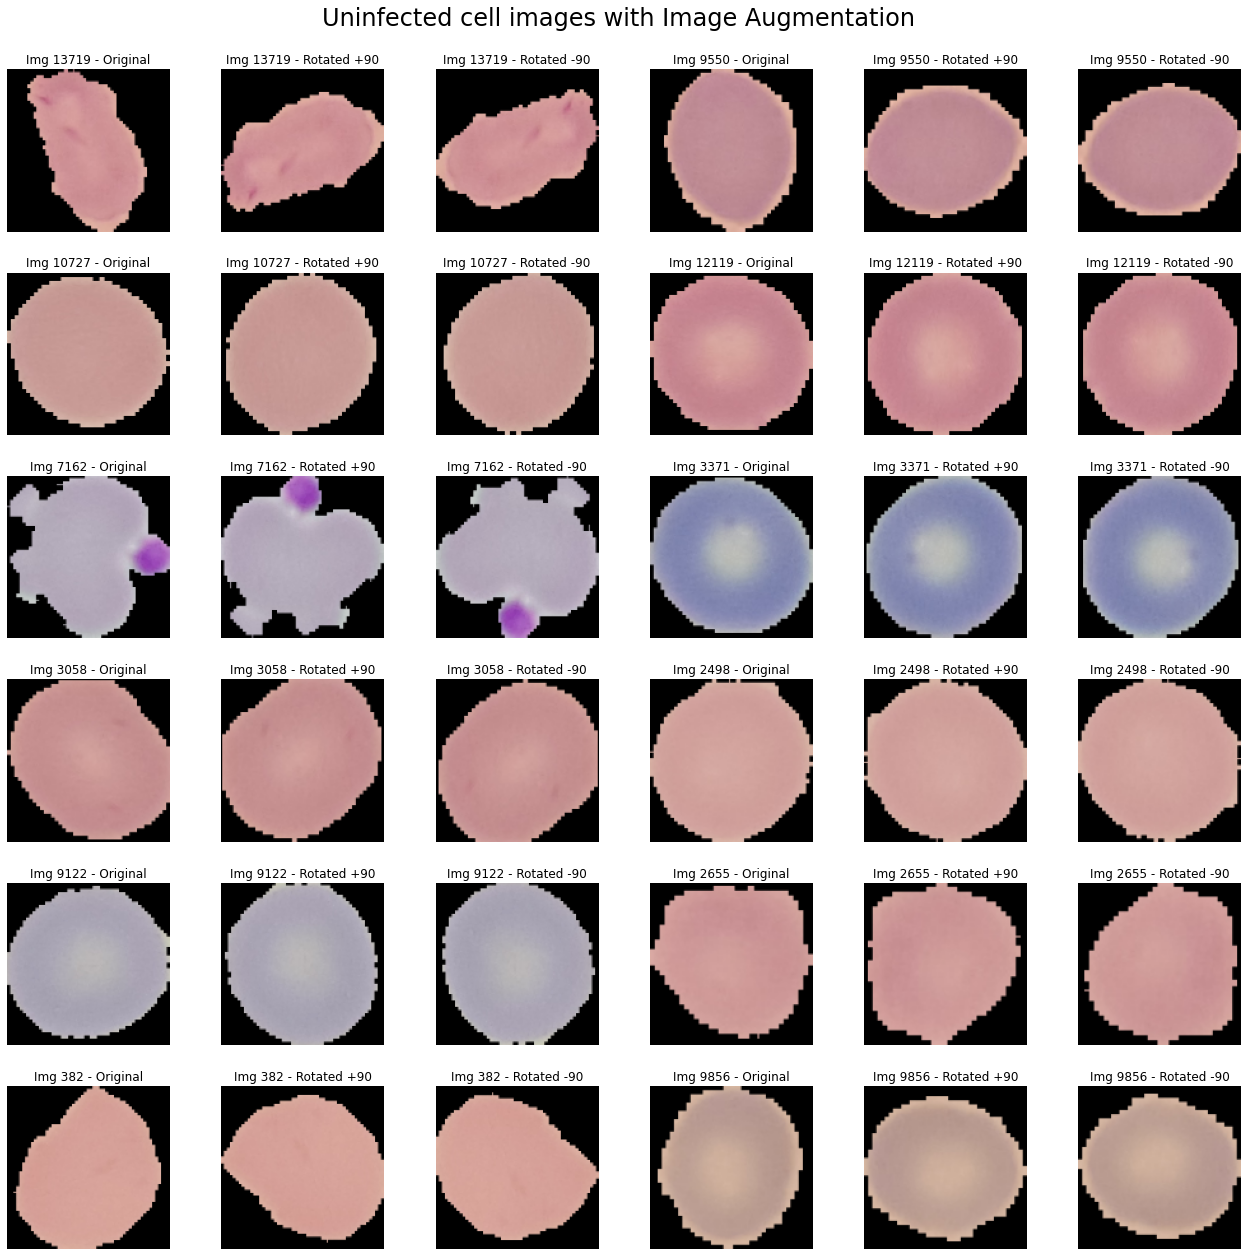

In [9]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Uninfected cell images with Image Augmentation', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 12)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {imgIndex} - Original")
    plt.imshow(imageData[imgIndex * 3])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {imgIndex} - Rotated +90")
    plt.imshow(imageData[(imgIndex * 3) + 1])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {imgIndex} - Rotated -90")
    plt.imshow(imageData[(imgIndex * 3) + 2])

plt.show()

### Data splitting

In [10]:
X_train, X_val = train_test_split(
    imageData, 
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE
    )

print(f'Training Data: {X_train.shape}')
print(f'\nValidation Data: {X_val.shape}')

Training Data: (39270, 128, 128, 3)

Validation Data: (2067, 128, 128, 3)


### Memory usage reduction

In [11]:
del imageData

## Model Creation

### Input Layer

In [12]:
inputLayer = Input(shape = (*IMAGE_SIZE, 3), name = 'Input')

### Encoder

In [13]:
depth_conv = DepthwiseConv2D((4, 4), activation = LeakyReLU(), padding = 'same', depth_multiplier = 2, name = "Depth_Conv")(inputLayer)
depth_conv.shape

TensorShape([None, 128, 128, 6])

In [14]:
conv_1 = Conv2D(8, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_1")(depth_conv)
pool_1 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_1")(conv_1)
pool_1.shape

TensorShape([None, 32, 32, 8])

In [15]:
conv_2 = Conv2D(16, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_2")(pool_1)
pool_2 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_2")(conv_2)
pool_2.shape

TensorShape([None, 8, 8, 16])

In [16]:
conv_3 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_3")(pool_2)
pool_3 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_3")(conv_3)
pool_3.shape

TensorShape([None, 4, 4, 32])

In [17]:
conv_4 = Conv2D(64, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_4")(pool_3)
pool_4 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_4")(conv_4)
pool_4.shape

TensorShape([None, 2, 2, 64])

### Decoder

In [18]:
conv_5 = Conv2D(64, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_1")(pool_4)
up_1 = UpSampling2D((2, 2), name = "Dec_Upsampling_1")(conv_5)
up_1.shape

TensorShape([None, 4, 4, 64])

In [19]:
conv_6 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_2")(up_1)
up_2 = UpSampling2D((2, 2), name = "Dec_Upsampling_2")(conv_6)
up_2.shape

TensorShape([None, 8, 8, 32])

In [20]:
conv_7 = Conv2D(16, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_3")(up_2)
up_3 = UpSampling2D((4, 4), name = "Dec_Upsampling_3")(conv_7)
up_3.shape

TensorShape([None, 32, 32, 16])

In [21]:
conv_8 = Conv2D(8, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_4")(up_3)
up_4 = UpSampling2D((4, 4), name = "Dec_Upsampling_4")(conv_8)
up_4.shape

TensorShape([None, 128, 128, 8])

In [22]:
dropout = Dropout(0.1, name = "Dropout")(up_4)
dropout.shape

TensorShape([None, 128, 128, 8])

In [23]:
outputLayer = Conv2D(3, (1, 1), activation = 'sigmoid', padding = 'same', name = 'Reconstruction_Output')(dropout)
outputLayer.shape

TensorShape([None, 128, 128, 3])

### Model compilation

In [24]:
autoencoder = Model(inputs = inputLayer, outputs = outputLayer, name = MODEL_NAME)
autoencoder.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy')

### Model Summary

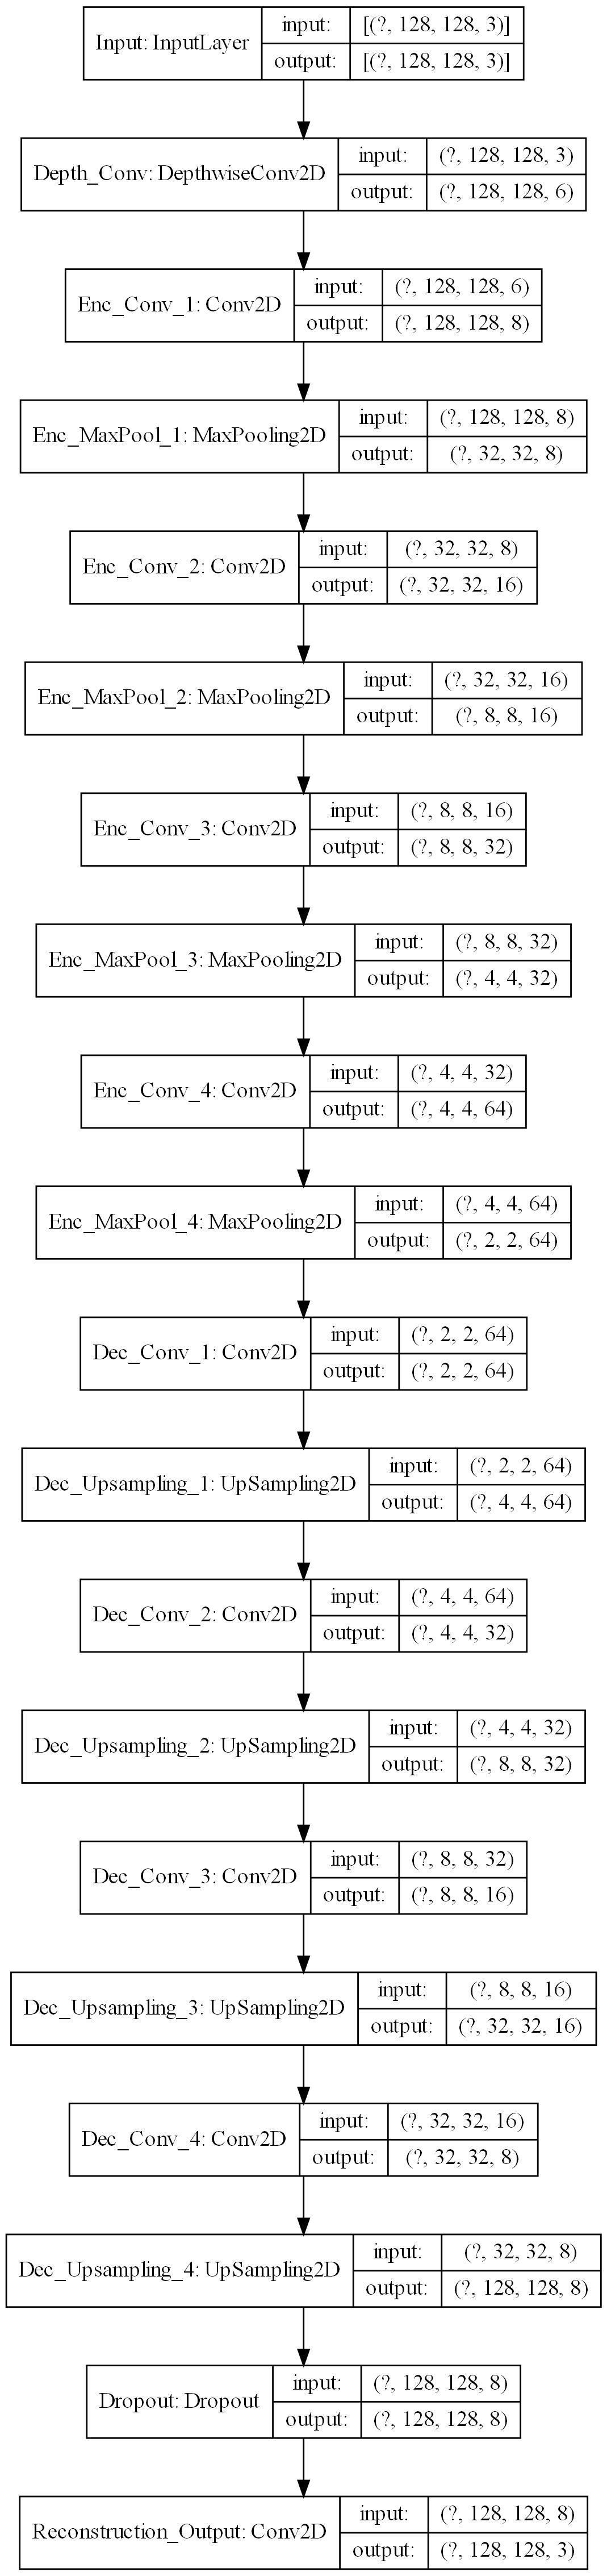

In [25]:
tf.keras.utils.plot_model(autoencoder, to_file = os.path.join(PLOTS_DIR, 'model.jpg'), show_shapes = True, dpi = PLOTS_DPI)

In [26]:
autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
Depth_Conv (DepthwiseConv2D) (None, 128, 128, 6)       102       
_________________________________________________________________
Enc_Conv_1 (Conv2D)          (None, 128, 128, 8)       776       
_________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
Enc_Conv_2 (Conv2D)          (None, 32, 32, 16)        2064      
_________________________________________________________________
Enc_MaxPool_2 (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
Enc_Conv_3 (Conv2D)          (None, 8, 8

## Model Training

### Callbacks

In [27]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

### Training history

In [28]:
%%time

history = autoencoder.fit(
    X_train, 
    X_train, 
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS, 
    verbose = 1, 
    validation_data = (X_val, X_val),
    callbacks = [earlyStop]
    )

Epoch 1/100
614/614 [==============================] - 75s 122ms/step - loss: 0.4773 - val_loss: 0.4503
Epoch 2/100
614/614 [==============================] - 74s 120ms/step - loss: 0.4519 - val_loss: 0.4452
Epoch 3/100
614/614 [==============================] - 74s 121ms/step - loss: 0.4482 - val_loss: 0.4427
Epoch 4/100
614/614 [==============================] - 74s 121ms/step - loss: 0.4464 - val_loss: 0.4414
Epoch 5/100
614/614 [==============================] - 74s 121ms/step - loss: 0.4453 - val_loss: 0.4406
Epoch 6/100
614/614 [==============================] - 75s 121ms/step - loss: 0.4445 - val_loss: 0.4399
Epoch 7/100
614/614 [==============================] - 75s 121ms/step - loss: 0.4438 - val_loss: 0.4392
Epoch 8/100
614/614 [==============================] - 75s 122ms/step - loss: 0.4433 - val_loss: 0.4390
Epoch 9/100
614/614 [==============================] - 74s 121ms/step - loss: 0.4429 - val_loss: 0.4382
Epoch 10/100
614/614 [==============================] - 75s 122m

## Model Evaluation

### Model Loss over Epochs

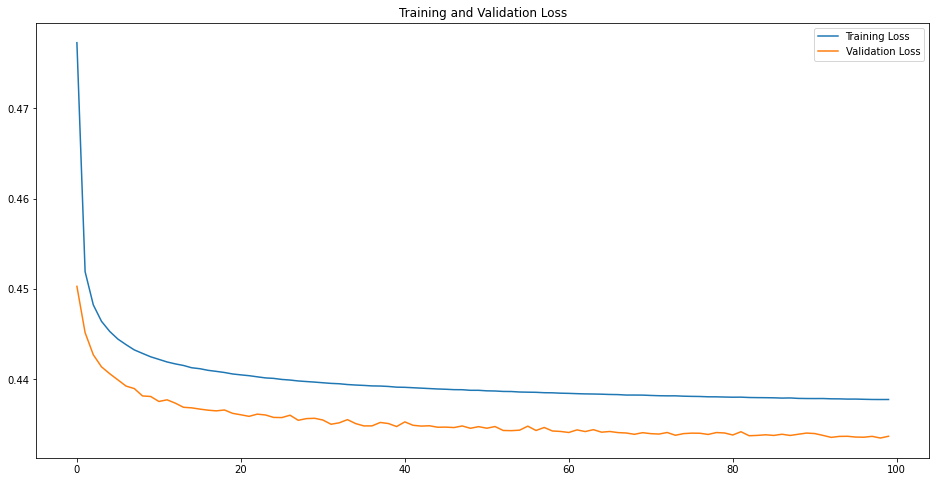

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig(os.path.join(PLOTS_DIR, 'acc_and_loss.jpg'), dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

### Prediction Visualization

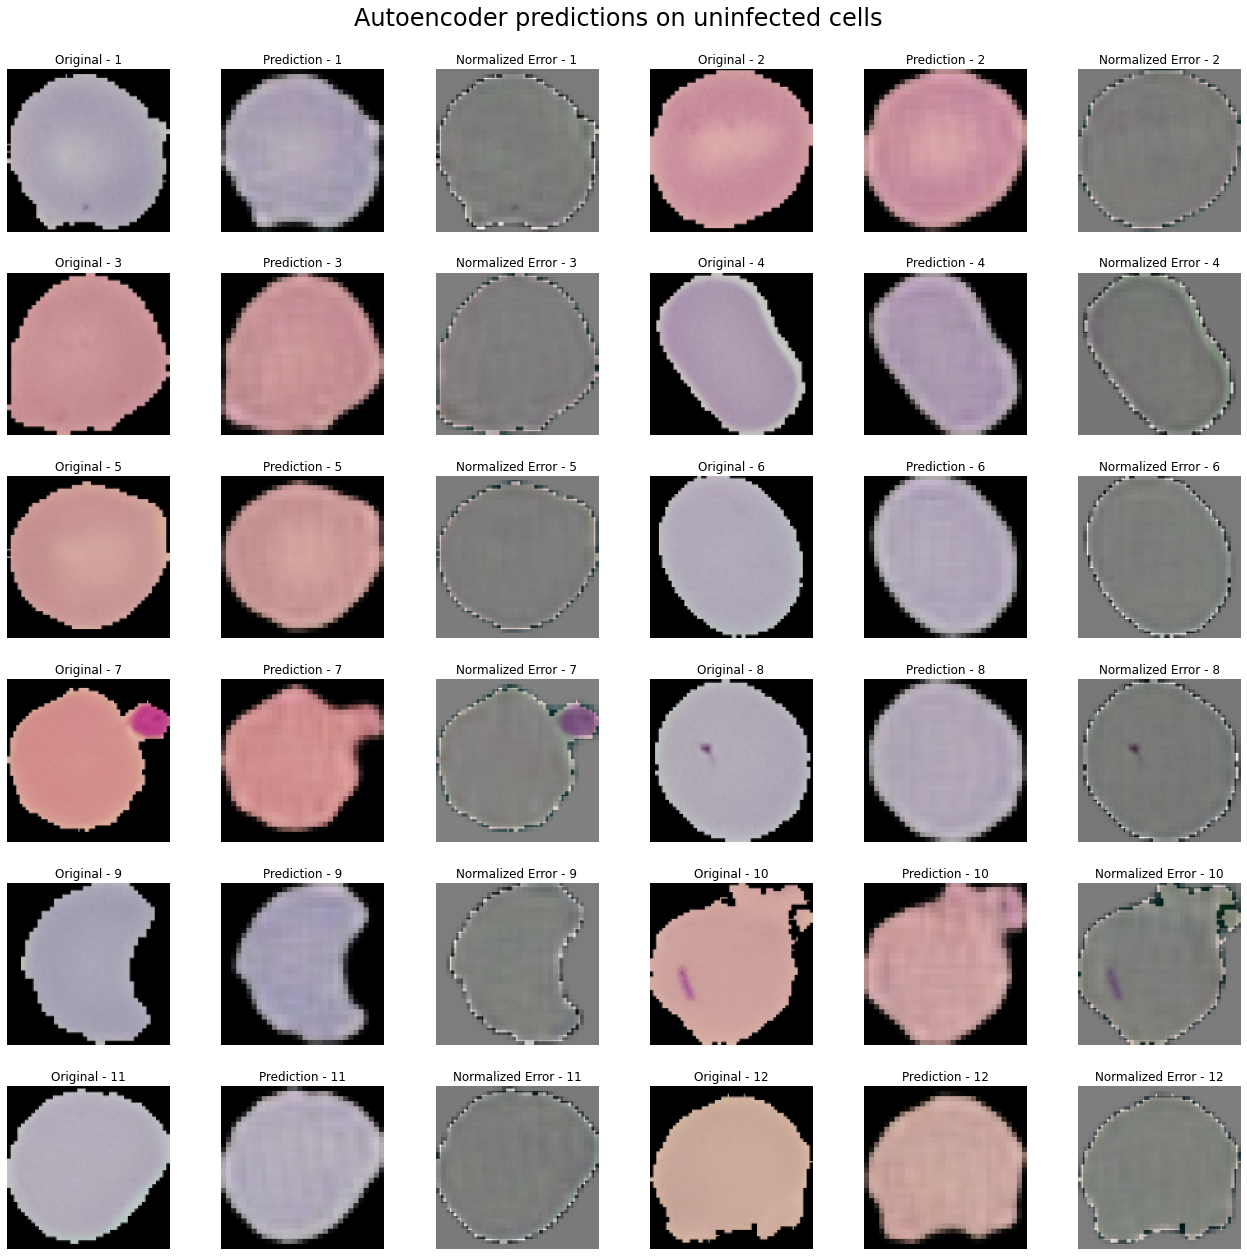

In [30]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Autoencoder predictions on uninfected cells', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

val_data = X_val[np.random.randint(0, len(X_val), size = 12)]
pred = autoencoder.predict(val_data)
pred_error = val_data - pred
pred_error_min = pred_error.min(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
pred_error_max = pred_error.max(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
norm_error = (pred_error - pred_error_min)/(pred_error_max - pred_error_min)

for i in range(len(val_data)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Original - {i + 1}")
    plt.imshow(val_data[i])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Prediction - {i + 1}")
    plt.imshow(pred[i])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Normalized Error - {i + 1}")
    plt.imshow(norm_error[i])

plt.savefig(os.path.join(PLOTS_DIR, 'predictions.jpg'), dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Model Saving

In [31]:
autoencoder.save(os.path.join('models', MODEL_NAME))